In [2]:
os.environ['NEPTUNE_API_TOKEN']="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiYjdhNDIyNTAtOWRlNC00ZGI1LWJjN2EtOTdiNzM5ODg2MDNjIn0=";
os.environ['POSTGRES_SERVER']="first-foundation.cr3hljeym9yl.us-west-2.rds.amazonaws.com";
os.environ['POSTGRES_PORT']="5432";
os.environ['POSTGRES_USER']="postgres";
os.environ['POSTGRES_OPTUNA_USER']="optunauser";
os.environ['POSTGRES_OPTUNA_PASSWORD']="gR190089IxaArsyYQa";

In [3]:
# import hdf5plugin, h5py
import torch, tables
from torch import nn
import os
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from functools import partial
from tqdm.auto import tqdm
from typing import Any
import torchvision
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np
from dataclasses import dataclass
from typing import Callable
import cv2, functools, glia
import pytorch_lightning as pl
from pytorch_lightning.loggers.neptune import NeptuneLogger
import neptune
import neptunecontrib.monitoring.optuna as optuna_utils
from optuna.integration.pytorch_lightning import PyTorchLightningPruningCallback
import optuna
from datetime import datetime
import socket, plotly
from pathlib import Path
import torch.nn, gc, psycopg2
import sys, traceback
from glia.reconstructions.lib import resize_3d, gray_3d, ImageData, RetinaData, \
     ConcatDataset, ImageRetina
from sqlalchemy import create_engine

sys.argv = [None, "/mnt/fs1/tbenst/200623_faces/R1_E3_AMES_200min_200f_14l_rgb.h5",
            "/mnt/fs1/tbenst/models/3brain/", "9"]

filepath = sys.argv[1]
# model_base_dir = "/storage/models/retina-reconstruction"
model_base_dir = sys.argv[2]
gpus = [ int(sys.argv[3]) ]

pw = os.environ["POSTGRES_OPTUNA_PASSWORD"]
server = os.environ["POSTGRES_SERVER"]
port = os.environ["POSTGRES_PORT"]
user = os.environ["POSTGRES_OPTUNA_USER"]
# validate password

engine = create_engine(f'postgresql://{user}:{pw}@{server}:{port}/optuna')
with engine.connect() as connection:
    result = connection.execute("select * from trials limit 1;")


# open file
hdf5 = tables.open_file(filepath,'r')
h5 = hdf5.root

# crop image
imgs = h5["images"][0:100]
avg_img = np.mean(imgs, axis=(0,3))
y,x = np.where(avg_img>5)
xleft = min(x)
xright = max(x)
ytop = min(y)
ybot = max(y)

image_dset = ImageData(h5["images"], crop=[ytop,ybot,xleft,xright])
retina_dset = RetinaData(h5["data"], no_units=False)
(image_dset[0].shape, retina_dset[0].shape)

(torch.Size([1, 64, 64]), torch.Size([10, 6, 64, 64]))

In [6]:
cache_path = "/mnt/fs1/tbenst/200623_faces/R1_E3_AMES_200min_200f_14l_rgb_cache.npy"
john_dataset = np.load(cache_path)

In [7]:
imgs = h5["images"][0:100]
y,x = np.where(np.mean(imgs, axis=(0,3))>5)
xleft, xright, ytop, ybot = min(x), max(x), min(y), max(y)

images = h5["images"][:,ytop:ybot,xleft:xright]

tiny_images = []
for i in range(len(images)):
    tiny_images.append(cv2.resize(images[i],(64,64)))
images = np.stack(tiny_images)

In [8]:
john_targets = torch.tensor(images).float().mean(3)/255.

In [9]:
john_targets[0]

tensor([[0.7333, 0.7333, 0.7333,  ..., 0.7176, 0.7176, 0.7176],
        [0.7373, 0.7373, 0.7373,  ..., 0.7176, 0.7176, 0.7137],
        [0.7373, 0.7373, 0.7373,  ..., 0.7150, 0.7176, 0.7137],
        ...,
        [0.6667, 0.6667, 0.6588,  ..., 0.1699, 0.1425, 0.1673],
        [0.6549, 0.6549, 0.6549,  ..., 0.1686, 0.1359, 0.1608],
        [0.6549, 0.6549, 0.6549,  ..., 0.1673, 0.1373, 0.1490]])

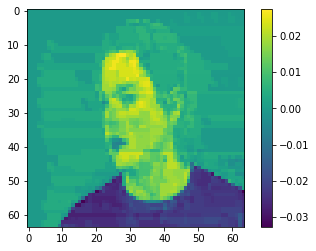

In [10]:
plt.imshow(image_dset[0].numpy()[0]-john_targets[0].numpy())
plt.colorbar()

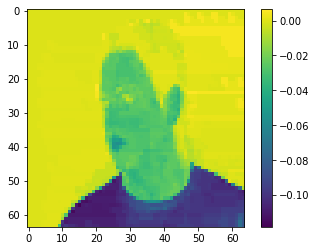

In [48]:
plt.imshow(image_dset[0].numpy()[0]-john_targets[0].numpy())
plt.colorbar()

In [47]:
john_targets[0].numpy().shape

(64, 64)

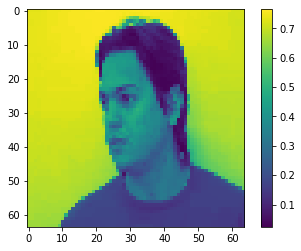

In [12]:
plt.imshow(image_dset[0].numpy()[0])
plt.colorbar()

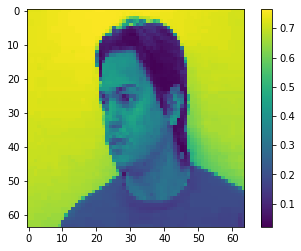

In [11]:
plt.imshow(john_targets[0].numpy())
plt.colorbar()

In [155]:
image_dset[0].shape

torch.Size([1, 64, 64])

In [158]:
class Block(torch.nn.Module):
    def __init__(self, filters):
        super(Block, self).__init__()
        
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters), torch.nn.ReLU(),
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters))
        
    def forward(self, x):
        return F.relu(x + self.block(x))
    
class ConvNet(pl.LightningModule):
    def __init__(self, filters=128, nLayers=101, lr=3e-4, kernel1=9, weight_decay=0.,
                example_input_array=retina_dset[0][None]):
        super(ConvNet, self).__init__()
        self.filters = filters
        self.lr = lr
        self.weight_decay=weight_decay
        
        self.save_hyperparameters()
        
        self.conv_in = torch.nn.Conv2d(10*6, filters, kernel1, padding=4, stride=4, bias=False)
        
        self.resnet = torch.nn.ModuleList()
        for i in range(nLayers): self.resnet.append(Block(filters))
            
        self.conv_out =  torch.nn.ConvTranspose2d(self.filters, 1, 8, stride=8, bias=True)
        self.bias = torch.nn.Parameter(torch.Tensor(64,64))
        
        for name, parm in self.named_parameters():
            if name.endswith('weight'): torch.nn.init.normal_(parm, 0, .01)
            if name.endswith('bias'): torch.nn.init.constant_(parm, 0.0)
    
    def forward(self, x):
        x = x.reshape(-1,10*6,64,64)[:,:,::2,::2].contiguous() # factor of 2 downsampling
        zx = F.relu(self.conv_in(x))
        for layer in self.resnet: zx = layer(zx)
        return torch.sigmoid(self.conv_out(zx).squeeze() + self.bias[None,:,:])
    
    def loss(self, batch, batch_idx):        
        images, retina = batch
        retina = retina/30 # scale 
        images = images[:,0] # remove singleton
        im_pred = self(retina)
#         loss = F.mse_loss(im_pred, images, reduction='mean')
        loss = ((im_pred - images)**2).sum(1).mean()
        recon_loss = F.mse_loss(im_pred, images, reduction='sum') / images.shape[0]
        return {"recon_loss": recon_loss, "loss": loss}
        
    
    def training_step(self, batch, batch_idx):
        loss_dict = self.loss(batch, batch_idx)
        loss, recon_loss = loss_dict["loss"], loss_dict["recon_loss"]
        result = pl.TrainResult(loss)
        result.log('reconstruction_loss', recon_loss, prog_bar=True)
        return result
        
    def validation_step(self, batch, batch_idx):
        loss_dict = self.loss(batch, batch_idx)
        loss, recon_loss = loss_dict["loss"], loss_dict["recon_loss"]
        result = pl.EvalResult(checkpoint_on=loss)
        result.log('val_mse_loss', recon_loss, on_epoch=True)
        return result

    def test_step(self, batch, batch_idx):
        loss_dict = self.calc_loss(batch, batch_idx)
        loss, recon_loss = loss_dict["loss"], loss_dict["recon_loss"]
        return recon_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr,
            weight_decay=self.weight_decay)
        return optimizer
    

In [159]:
nSamples = len(retina_dset)
train_idx = [i for i in range(nSamples) if (i+1)%5 != 0]
val_idx = np.arange(nSamples)[slice(4,nSamples,10)]
test_idx = np.arange(nSamples)[slice(9,nSamples,10)]
dm = ImageRetina(image_dset, retina_dset,batch_size=50,
                 tvt_idxs=(train_idx, val_idx, test_idx))

model_base_dir = "/mnt/fs1/tbenst/models/3brain/"
now_str = datetime.now().isoformat()
save_dir = os.path.join(model_base_dir,
    now_str)

MODEL_NAME="john_convnet"
model = ConvNet()

neptune_logger = NeptuneLogger(
    api_key=os.environ["NEPTUNE_API_TOKEN"],
    project_name="tbenst/retina",
    params=model.hparams,
    experiment_name=MODEL_NAME,  # Optional,
    tags=["john_convnet"]
)

monitor="val_mse_loss"
save_name = MODEL_NAME+"_{epoch}_{"+monitor+":.2f}"
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=os.path.join(save_dir,save_name),
    save_top_k=1,
    verbose=False,
    monitor=monitor,
    mode='min',
    prefix=''
)
    
trainer = pl.Trainer(gpus=[9], logger=neptune_logger, default_root_dir=save_dir)
trainer.fit(model, dm)

https://ui.neptune.ai/tbenst/retina/e/RET-1297


NeptuneLogger will work in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [9]

  | Name     | Type            | Params
---------------------------------------------
0 | conv_in  | Conv2d          | 622 K 
1 | resnet   | ModuleList      | 29 M  
2 | conv_out | ConvTranspose2d | 8 K   


Saving latest checkpoint..


1

In [25]:
for batch in dm.val_dataloader():
    bz = batch[0].shape[0]
    images, retina = batch
    images_pred = model(retina)
    mse = F.mse_loss(images, images_pred, reduction="sum")/bz
    print(f"{mse=}")
    break

comparison = torch.cat([images.view(-1,1,64, 64),
               images_pred.view(-1,1,64, 64).cpu()],axis=2).detach()
comparison = torchvision.utils.make_grid(comparison, nrow=12).numpy()
comparison = np.moveaxis(comparison,0,-1)
plt.figure(figsize=(20,20))
plt.imshow(comparison)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [20]:
data

NameError: name 'data' is not defined

In [65]:
# data = torch.tensor(john_dataset)/30. # scaling
data = torch.tensor(retina_dset[:]/30)
# targets = john_targets
targets = torch.tensor(image_dset.images[:])[:,:,:,0]

train_data = data[[i for i in range(2800) if (i+1)%5 != 0]]
val_data = data[slice(4,2800,10)]
test_data = data[slice(9,2800,10)]

train_targets = targets[[i for i in range(2800) if (i+1)%5 != 0]]
val_targets = targets[slice(4,2800,10)]
test_targets = targets[slice(9,2800,10)]

In [140]:
device = 'cuda:9'
model = ConvNet().to(device)

count = sum([np.prod(parm.shape) for parm in model.parameters() if parm.requires_grad])
print('Initialized a graph with {} parameters'.format(count))

train_history = []
val_history = []

model.eval()
loss = 0.
for i in np.random.permutation(len(val_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).sum(1).mean()
val_history.append(loss/(len(val_data)//batch_size))
print('Initial Loss: {:2f}'.format(val_history[-1]))

Initialized a graph with 30472193 parameters
Initial Loss: 4.016769


tensor_dataset = torch.utils.data.TensorDataset(train_data, train_targets)

In [109]:
dm = ImageRetina(image_dset, retina_dset,batch_size=50,
                 tvt_idxs=(train_idx, val_idx, test_idx))
for batch in dm.train_dataloader():
    print(batch[0].shape)
    print(batch[1].shape)
    break

torch.Size([50, 1, 64, 64])
torch.Size([50, 10, 6, 64, 64])


In [127]:
image_dset.images

array([[[[0.73333335],
         [0.73333335],
         [0.73333335],
         ...,
         [0.7176471 ],
         [0.7176471 ],
         [0.7176471 ]],

        [[0.737255  ],
         [0.737255  ],
         [0.737255  ],
         ...,
         [0.7176471 ],
         [0.7176471 ],
         [0.7137255 ]],

        [[0.737255  ],
         [0.737255  ],
         [0.737255  ],
         ...,
         [0.715302  ],
         [0.7176471 ],
         [0.7137255 ]],

        ...,

        [[0.6666667 ],
         [0.6666667 ],
         [0.65882355],
         ...,
         [0.14905098],
         [0.12765098],
         [0.1471098 ]],

        [[0.654902  ],
         [0.654902  ],
         [0.654902  ],
         ...,
         [0.14570196],
         [0.12033725],
         [0.13753726]],

        [[0.654902  ],
         [0.654902  ],
         [0.654902  ],
         ...,
         [0.14339998],
         [0.12078431],
         [0.12577255]]],


       [[[0.7578824 ],
         [0.76572555],
         [0.76

In [132]:
tensor_dataset[0][0].shape, tensor_dataset[0][1].shape

(torch.Size([64, 64, 1]), torch.Size([10, 6, 64, 64]))

In [150]:
np.all((train_data == data[train_idx]).numpy())

True

In [151]:
image_dset[0].shape

torch.Size([1, 64, 64])

In [152]:
image_dset.images.shape

(2800, 64, 64, 1)

In [153]:
batch_size = 50
optimizer = torch.optim.Adam(model.parameters(), lr=.0003)

# dl = dm.train_dataloader() # broken!!!

# WORKS
# tensor_dataset = torch.utils.data.TensorDataset(train_targets, train_data)

# BROKEN
# concat_dataset = glia.reconstructions.lib.ConcatDataset(
#             image_dset, retina_dset
#         )

# BROKEN
# concat_dataset = torch.utils.data.TensorDataset(torch.tensor(np.moveaxis(image_dset.images,-1,1)), retina_dset.data)
# tensor_dataset = torch.utils.data.Subset(concat_dataset, train_idx)

# ALSO BROKEN
tensor_dataset = torch.utils.data.TensorDataset(torch.tensor(image_dset.images[train_idx,:,:,0]),
                                                retina_dset.data[train_idx]/30)

dl = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size,
                                shuffle=True)


try:
    print('epoch\ttrain loss\ttest loss\ttime\t\tutime')
    t0 = time.time()
    for epoch in range(500):
        model.train()
        loss_train = 0
        for batch in dl:
#             x, z = batch # for john preprocess
            z, x = batch # for pl.DataModule
            x = x.to(device)
            z = z.to(device)
#         for i in np.random.permutation(len(train_data)//batch_size):
#             start, end = i*batch_size, (i+1)*batch_size
#             x,z = train_data[start:end].to(device), train_targets[start:end].to(device)
            loss = ((model(x) - z)**2).sum(1).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.detach()
        train_history.append(loss_train/(len(train_data)//batch_size))

        if epoch % 1 == 0:
            t1 = time.time()
            model.eval()
            loss = 0.
            for i in range(len(val_data)//batch_size):
                start, end = i*batch_size, (i+1)*batch_size
                x,z = val_data[start:end].to(device), val_targets[start:end].to(device)
                loss += ((model(x).detach() - z)**2).sum(1).mean()
            val_history.append(loss/(len(val_data)//batch_size))
            print('{:d}\t{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(epoch,train_history[-1],val_history[-1],time.time()-t0, time.time()-t1))
            t0 = time.time()
            
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print('Finished')

epoch	train loss	test loss	time		utime
0	1.154031	1.016950	8.036778	0.247046
1	0.720567	0.734881	10.624638	0.223562
2	0.639913	0.787906	8.667985	0.246063
3	0.585177	0.682341	10.967961	0.256278
Graceful Exit


In [93]:
model.eval()
loss = 0.
for i in np.random.permutation(len(test_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = test_data[start:end].cuda(), test_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).view(-1,64*64).sum(1).mean()
print('Final Loss: {:2f}'.format(loss/(len(test_data)//batch_size)))

Final Loss: 39.279232


In [94]:
retina.shape

torch.Size([50, 10, 6, 64, 64])

mse=tensor(11.4639)


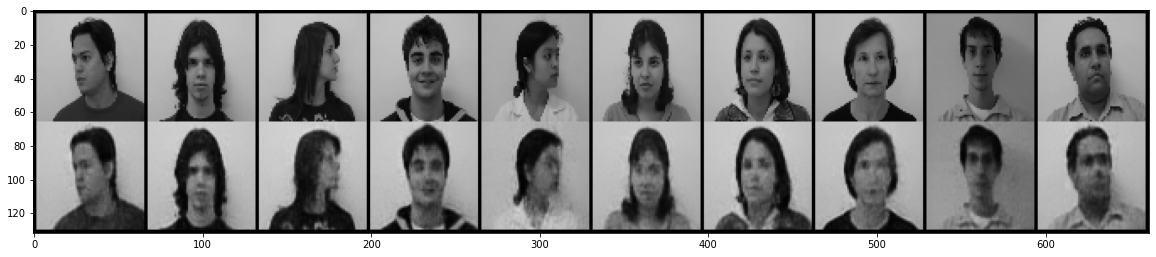

In [95]:
# for batch in dm.val_dataloader():
#     bz = batch[0].shape[0]
#     images, retina = batch
#     images_pred = model(retina.to(device)/30)
#     mse = F.mse_loss(images, images_pred.cpu(), reduction="sum")/bz
#     print(f"{mse=}")
#     break

images = train_targets[0:10]
images_pred = reconstructions
comparison = torch.cat([images.view(-1,1,64, 64),
               images_pred.view(-1,1,64, 64).cpu()],axis=2).detach()
comparison = torchvision.utils.make_grid(comparison, nrow=12).numpy()
comparison = np.moveaxis(comparison,0,-1)
plt.figure(figsize=(20,20))
plt.imshow(comparison)
mse = F.mse_loss(images, images_pred, reduction="sum")/images.shape[0]
print(f"{mse=}")

In [43]:
bz

50

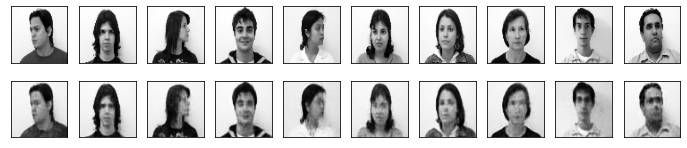

In [74]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))

model.eval()
reconstructions = model(train_data[0:10].cuda()).detach().cpu()
for i in range(10):
    ax[0,i].imshow(train_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i],cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])

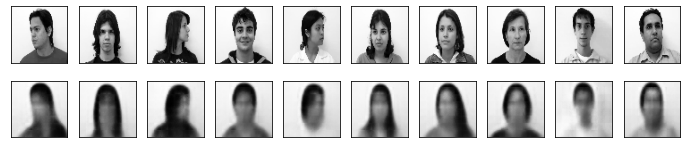

In [39]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))

model.eval()
reconstructions = model(train_data[0:10].cuda()).detach().cpu()
for i in range(10):
    ax[0,i].imshow(train_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i],cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])

In [9]:
import torch, tables
from torch import nn
import os
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from functools import partial
from tqdm.auto import tqdm
from typing import Any
import torchvision
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np
from dataclasses import dataclass
from typing import Callable
import cv2, functools, glia
from pytorch_lightning.loggers.neptune import NeptuneLogger
import neptune
import neptunecontrib.monitoring.optuna as optuna_utils
from optuna.integration.pytorch_lightning import PyTorchLightningPruningCallback
import optuna
from datetime import datetime
import socket, plotly
from pathlib import Path
import torch.nn, gc, psycopg2
import sys, traceback

# Kingma & Welling (2014) style variational autoencoder

# subclass PyTorch Module for reverse-mode autodifferentiation 
# for easy backpropogation of loss gradient

def sample_model(trial, datamodule, save_dir):
    retina_dset = datamodule.retina_dset
    nTimeSteps, nUnitChannels, meaH, meaW = retina_dset[0].shape
    image_dset = datamodule.images_dset
    imageChannels, H, W = image_dset[0].shape

    nCelltypes = trial.suggest_int("nCelltypes", 1, 32)
    kernel1 = trial.suggest_int("kernel1", 1, 16)*2-1 # must be odd
    kernel2 = trial.suggest_int("kernel2", 1, 16)*2-1 # must be odd
    nLayers = trial.suggest_int("nLayers", 1, 8)
    nBlockChannels = trial.suggest_int("nBlockChannels", 1, 64)
    nonlinearity = trial.suggest_categorical("nonlinearity",
        ["relu", "celu", "sigmoid", "tanh", "leaky_relu", "gelu", "hardswish"])
    # batch_size =  trial.suggest_categorical("batch_size",
    #     [1,4,8,16,32,64,128,256,512])
    batch_size = 64
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-4,1.)

    # lr = trial.suggest_loguniform("lr", 1e-8,1.)
    # beta = trial.suggest_loguniform("beta", 1e-6,1e3)
    beta = 0
    
    hostname = socket.gethostname()

    model = ResnetDecoder(H=H, W=W, imageChannels=imageChannels,
        nTimeSteps=nTimeSteps, 
        nCelltypes=nCelltypes,
        kernel1=kernel1, kernel2=kernel2, nLayers=nLayers,
        nBlockChannels=nBlockChannels,
        nUnitChannels=nUnitChannels, meaH=meaH, meaW=meaW,
        nonlinearity=nonlinearity,beta=beta, weight_decay=weight_decay,
        example_input_array=retina_dset[0][None],
        # lr=lr, 
        save_dir=save_dir, hostname=hostname, batch_size=batch_size)
    datamodule.batch_size = batch_size
    return model, datamodule

def convLayer(in_chan, out_chan, kernel=9):
    return nn.Conv2d(in_chan, out_chan, kernel_size=kernel,
                     padding=kernel//2, bias=False)


class BasicBlock(nn.Module):

    def __init__(self, in_chan, out_chan, nonlinearity=F.relu):
        super(BasicBlock, self).__init__()
        self.conv1 = convLayer(in_chan, out_chan)
        self.bn1 = nn.BatchNorm2d(out_chan)
        self.nonlinearity = nonlinearity
        self.conv2 = convLayer(out_chan, out_chan)
        self.bn2 = nn.BatchNorm2d(out_chan)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.nonlinearity(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += residual
        out = self.nonlinearity(out)

        return out


@dataclass(unsafe_hash=True)
class ResnetDecoder(pl.LightningModule):
    "Given retina firing rates, reconstruct image"
        
    def __init__(self, hostname:str, save_dir:str, example_input_array,
            imageChannels:int = 3,
            nUnitChannels:int = 6, nBlockChannels:int = 16,
            meaH:int = 64, meaW:int = 64, H:int = 64, nLayers:int = 4,
            W:int = 64, nTimeSteps:int = 10, nCelltypes:int = 8,
            kernel1:int = 15, kernel2:int = 15, lr:float = 1e-3,
            batch_size:int = 64, weight_decay: float = 1e-3, beta:float = 1,
            nonlinearity:Callable = F.sigmoid):
        super().__init__()
        self.hostname = hostname
        self.save_dir = save_dir
        self.imageChannels = imageChannels
        self.nUnitChannels = nUnitChannels
        self.nBlockChannels = nBlockChannels
        self.meaH = meaH
        self.meaW = meaW
        self.H = H
        self.W = W
        self.nTimeSteps = nTimeSteps
        self.nCelltypes = nCelltypes
        self.kernel1 = kernel1
        self.kernel2 = kernel2
        self.nLayers = nLayers
        self.lr = lr
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        self.beta = beta
        self.nonlinearity = nonlinearity
        self.example_input_array = example_input_array

        # all init args saved as hyperparam
        self.save_hyperparameters()

        if self.nonlinearity=="relu":
            self.nonlinearity = F.relu
        elif self.nonlinearity=="celu":
            self.nonlinearity = F.celu
        elif self.nonlinearity=="sigmoid":
            self.nonlinearity = F.sigmoid
        elif self.nonlinearity=="tanh":
            self.nonlinearity = F.tanh
        elif self.nonlinearity=="leaky_relu":
            self.nonlinearity = F.leaky_relu
        elif self.nonlinearity=="gelu":
            self.nonlinearity = F.gelu
        elif self.nonlinearity=="hardswish":
            self.nonlinearity = F.hardswish
        
        # TODO: loss of 1 - l2 norm on weights to encourage winner-takes-all
        cl = torch.FloatTensor(
            self.nCelltypes, self.nUnitChannels, self.meaH, self.meaW).fill_(
            1/self.nCelltypes)
        self.celltype_likelihood = nn.Parameter(cl) # uniform prior
        
        self.conv1 = nn.Conv2d(in_channels=self.nCelltypes*self.nTimeSteps,
            out_channels=self.nBlockChannels, kernel_size=self.kernel1,
            padding=self.kernel1//2)
        self.bn1 = nn.BatchNorm2d(self.nBlockChannels)

        layers = [BasicBlock(self.nBlockChannels, self.nBlockChannels, self.nonlinearity)
                  for i in range(self.nLayers)]
        conv2 = nn.Conv2d(in_channels=self.nBlockChannels,
            out_channels=self.imageChannels, kernel_size=self.kernel2,
            padding=self.kernel2//2)
        layers.append(conv2)
        self.layers = nn.Sequential(*layers)
  
        self.save_hyperparameters()
    
    def forward(self,x):
        "Retina -> Image response"
        # map each unit to canonical celltype
#         prob = F.softmax(self.celltype_likelihood, dim=0)
        print("SHAPES", x.shape, self.celltype_likelihood.shape)
        if self.training:
            x = torch.poisson(x)
        x = torch.einsum("btchw,nchw->btnhw", x, self.celltype_likelihood)
        # combine time and unit dimensions
        x = x.view(-1,self.nTimeSteps*self.nCelltypes, self.meaH, self.meaW)
        x = self.conv1(x)
        x = self.nonlinearity(self.bn1(x))
        x = self.layers(x)
        x = self.nonlinearity(x)
        return x
        
    def calc_loss(self, batch, batch_idx):
        images, retina = batch
        im_pred = self(retina)
        recon_loss = F.mse_loss(im_pred, images, reduction='sum') / images.shape[0]
        celltype_loss = (1 - self.celltype_likelihood.norm(dim=0)).mean()
        # TODO: WARN: beta is not used!
#         loss = self.beta * celltype_loss + recon_loss
        loss = recon_loss
        return {"loss": loss, "recon_loss": recon_loss, "celltype_loss": celltype_loss,
                "im_pred": im_pred}

    def training_step(self, batch, batch_idx):
        loss_dict = self.calc_loss(batch, batch_idx)
        loss, recon_loss, celltype_loss = loss_dict["loss"], \
            loss_dict["recon_loss"], loss_dict["celltype_loss"]
        result = pl.TrainResult(loss)
        result.log('train_loss', loss, prog_bar=True)
        result.log('reconstruction_loss', recon_loss, prog_bar=True)
        result.log('celltype_loss', celltype_loss, prog_bar=True)
        return result
        
    def validation_step(self, batch, batch_idx):
        loss_dict = self.calc_loss(batch, batch_idx)
        loss, recon_loss, celltype_loss, Y_pred = loss_dict["loss"], \
            loss_dict["recon_loss"], loss_dict["celltype_loss"], loss_dict["im_pred"]
        result = pl.EvalResult(checkpoint_on=loss)
        result.log('val_loss', loss, on_epoch=True)
        result.log('val_mse_loss', recon_loss, on_epoch=True)
        result.log('val_celltype_loss', celltype_loss, on_epoch=True)
        return result

    def test_step(self, batch, batch_idx):
        loss_dict = self.calc_loss(batch, batch_idx)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
            weight_decay=self.weight_decay)
        return optimizer

In [ ]:
# TODO add args
# MODEL_NAME = "VAE"
# from models.vae import sample_model
# study_name = "2020-09-14_FEI_VAE"

# study_name = "2020-09-14_FEI_conv-eigsum"
# MODEL_NAME = "conv-eigsum"
# from models.conv_eigsum import sample_model

study_name = "2020-09-14_FEI_resnet-eigsum"
MODEL_NAME = "resnet-eigsum"
# from models.resnet_eigsum import sample_model

def objective(trial, tags, save_dir, max_train_iter, datamodule,
        monitor='val_mse_loss', gpus=[0]):
    "Optuna objective"
    # gc.collect()
    # torch.cuda.empty_cache()
    save_dir = os.path.join(save_dir, f"trial_{trial.number}")
    model, datamodule = sample_model(trial, datamodule, save_dir)
    save_name = MODEL_NAME+"_{epoch}_{"+monitor+":.2f}"
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_dir,save_name),
        save_top_k=1,
        verbose=False,
        monitor=monitor,
        mode='min',
        prefix=''
    )

    neptune_logger = NeptuneLogger(
        api_key=os.environ["NEPTUNE_API_TOKEN"],
        project_name="tbenst/retina",
        params=model.hparams,
        experiment_name=MODEL_NAME,  # Optional,
        tags=["optuna-trial"] + tags
    )
    trainer = pl.Trainer(gpus=gpus, gradient_clip_val=0.5,
        logger=neptune_logger, checkpoint_callback=checkpoint_callback,
        early_stop_callback=PyTorchLightningPruningCallback(trial, monitor=monitor),
        max_epochs=max_train_iter, auto_lr_find=True,
        default_root_dir=save_dir)
    # https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.trainer.html#weights-save-path
    #     weights_save_path=save_dir)
    #                      logger=mlf_logger)
    # trainer = pl.Trainer(num_processes=1, gradient_clip_val=0.5)
    trainer.fit(model, datamodule)
    
    return trainer.logged_metrics[monitor]

nSamples = len(retina_dset)
train_idx = [i for i in range(nSamples) if (i+1)%5 != 0]
val_idx = np.arange(nSamples)[slice(4,nSamples,10)]
test_idx = np.arange(nSamples)[slice(9,nSamples,10)]
dm = ImageRetina(image_dset, retina_dset,batch_size=64,
                 tvt_idxs=(train_idx, val_idx, test_idx))

assert os.path.exists(model_base_dir)
now_str = datetime.now().isoformat()
save_dir = os.path.join(model_base_dir,
    now_str + "-optuna")

tags = [MODEL_NAME, now_str+"-optuna"]

# worthless for distributed training...
# neptune.init(project_qualified_name='tbenst/retina')
# neptune.create_experiment('optuna', tags=["optuna-master"] + tags)
# neptune_callback = optuna_utils.NeptuneCallback()

max_train_iter = 25
storage = f'postgresql://{user}:{pw}@{server}:{port}/optuna'
storage=None
pruner = optuna.pruners.HyperbandPruner(
    min_resource=1,
    max_resource=max_train_iter,
    reduction_factor=3
)

study = optuna.create_study(direction='minimize',
   study_name=study_name, pruner=pruner,
    storage=storage, load_if_exists=True
)
    
# catch RuntimeError ie CUDA error: device-side assert triggered
# TODO not a good idea...?
study.optimize(partial(objective, tags=tags, save_dir=save_dir,
        max_train_iter=max_train_iter, datamodule=dm, gpus=gpus),
    # callbacks=[neptune_callback],
    timeout=60*60*8, gc_after_trial=True)
# optuna_utils.log_study(study)

[I 2020-09-16 03:51:19,234] A new study created in memory with name: 2020-09-14_FEI_resnet-eigsum


https://ui.neptune.ai/tbenst/retina/e/RET-1298


NeptuneLogger will work in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [9]

  | Name     | Type            | Params
---------------------------------------------
0 | conv_in  | Conv2d          | 622 K 
1 | resnet   | ModuleList      | 29 M  
2 | conv_out | ConvTranspose2d | 8 K   


Saving latest checkpoint..
LR finder stopped early due to diverging loss.
Learning rate set to 7.585775750291837e-08

  | Name     | Type            | Params
---------------------------------------------
0 | conv_in  | Conv2d          | 622 K 
1 | resnet   | ModuleList      | 29 M  
2 | conv_out | ConvTranspose2d | 8 K   


Exception ignored in: <function _releaseLock at 0x7f9527b303a0>
Traceback (most recent call last):
  File "/home/tbenst/miniconda3/envs/py38/lib/python3.8/logging/__init__.py", line 223, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


In [172]:
import torch, tables
from torch import nn
import os
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from functools import partial
from tqdm.auto import tqdm
from typing import Any
import torchvision
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np
from dataclasses import dataclass
from typing import Callable
import cv2, functools, glia
from pytorch_lightning.loggers.neptune import NeptuneLogger
import neptune
import neptunecontrib.monitoring.optuna as optuna_utils
from optuna.integration.pytorch_lightning import PyTorchLightningPruningCallback
import optuna
from datetime import datetime
import socket, plotly
from pathlib import Path
import torch.nn, gc, psycopg2
import sys, traceback

# Kingma & Welling (2014) style variational autoencoder

# subclass PyTorch Module for reverse-mode autodifferentiation 
# for easy backpropogation of loss gradient

def sample_model(trial, datamodule, save_dir):
    retina_dset = datamodule.retina_dset
    image_dset = datamodule.images_dset
    n_input = np.prod(retina_dset[0].shape)
    n_output = np.prod(image_dset[0].shape)
    H, W = image_dset[0].shape[1:]

    filters = trial.suggest_int("filters", 4,256)
    nLayers = trial.suggest_int("nLayers", 2,151)
    kernel1 = trial.suggest_int("kernel1", 1, 8)*2-1
    nonlinearity = trial.suggest_categorical("nonlinearity",
        ["relu", "celu", "sigmoid", "tanh", "leaky_relu", "gelu", "hardswish"])
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5,1e-1)

    poisson = trial.suggest_categorical("poisson",
        [True, False])
    einsum = trial.suggest_categorical("einsum",
        [True, False])
    if einsum:
        nCelltypes = trial.suggest_int("nCelltypes", 4,32)
    else:
        nCelltypes = 0
    ConvNet(filters=filters, nLayers=nLayers, kernel1=kernel1, nCelltypes=nCelltypes,
        weight_decay=weight_decay, poisson=poisson, einsum=einsum)
    datamodule.batch_size = batch_size
    return model, datamodule

class Block(torch.nn.Module):
    def __init__(self, filters):
        super(Block, self).__init__()
        
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters), torch.nn.ReLU(),
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters))
        
    def forward(self, x):
        return F.relu(x + self.block(x))
    
class ConvNet(pl.LightningModule):
    def __init__(self, filters=128, nLayers=101, lr=3e-4, kernel1=9, weight_decay=0.,
                poisson=False, einsum=False, nCelltypes=0,
                example_input_array=retina_dset[0][None]):
        super(ConvNet, self).__init__()
        self.filters = filters
        self.lr = lr
        self.weight_decay=weight_decay
        
        self.save_hyperparameters()
        if einsum:
            self.nCelltypes = nCelltypes
        else:
            self.nCelltypes = 6
        self.conv_in = torch.nn.Conv2d(10*self.nCelltypes, filters, kernel1, padding=4,
            stride=4, bias=False)
        
        self.resnet = torch.nn.ModuleList()
        for i in range(nLayers): self.resnet.append(Block(filters))
            
        self.conv_out =  torch.nn.ConvTranspose2d(self.filters, 1, 8, stride=8, bias=True)
        self.bias = torch.nn.Parameter(torch.Tensor(64,64))
        
        for name, parm in self.named_parameters():
            if name.endswith('weight'): torch.nn.init.normal_(parm, 0, .01)
            if name.endswith('bias'): torch.nn.init.constant_(parm, 0.0)

        cl = torch.FloatTensor(
        self.nCelltypes, 6, 64, 64).fill_(
            1/self.nCelltypes)
        self.celltype_likelihood = nn.Parameter(torch.tensor(cl)) # uniform prior
        self.register_parameter(name='celltype', param=self.celltype_likelihood)
    
    def forward(self, x):
        if self.poisson:
            x = torch.poisson(x)
        if self.einsum:
            x = torch.einsum("btchw,nchw->btnhw", x, self.celltype_likelihood)
        x = x.reshape(-1,10*6,64,64)[:,:,::2,::2].contiguous() # factor of 2 downsampling
        zx = F.relu(self.conv_in(x))
        for layer in self.resnet: zx = layer(zx)
        return torch.sigmoid(self.conv_out(zx).squeeze() + self.bias[None,:,:])
    
    def loss(self, batch, batch_idx):        
        images, retina = batch
        retina = retina/30 # scale 
        images = images[:,0] # remove singleton
        im_pred = self(retina)
#         loss = F.mse_loss(im_pred, images, reduction='mean')
        loss = ((im_pred - images)**2).sum(1).mean()
        recon_loss = F.mse_loss(im_pred, images, reduction='sum') / images.shape[0]
        return {"recon_loss": recon_loss, "loss": loss}
        
    
    def training_step(self, batch, batch_idx):
        loss_dict = self.loss(batch, batch_idx)
        loss, recon_loss = loss_dict["loss"], loss_dict["recon_loss"]
        result = pl.TrainResult(loss)
        result.log('reconstruction_loss', recon_loss, prog_bar=True)
        return result
        
    def validation_step(self, batch, batch_idx):
        loss_dict = self.loss(batch, batch_idx)
        loss, recon_loss = loss_dict["loss"], loss_dict["recon_loss"]
        result = pl.EvalResult(checkpoint_on=loss)
        result.log('val_mse_loss', recon_loss, on_epoch=True)
        return result

    def test_step(self, batch, batch_idx):
        loss_dict = self.calc_loss(batch, batch_idx)
        loss, recon_loss = loss_dict["loss"], loss_dict["recon_loss"]
        return recon_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr,
            weight_decay=self.weight_decay)
        return optimizer


In [ ]:
sample_modelle_modelle_modelle_model